# Lab 3 — clustering

In [150]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans
from operator import itemgetter
import random

%matplotlib inline
plt.style.use("ggplot")

In [5]:
with open("tags_in_5_dimensions.pickle", "rb") as f:
    tag_embeddings = pickle.load(f, encoding="utf-8")

In [9]:
for i in list(tag_embeddings)[:5]:
    print(i, tag_embeddings[i])

007 [-0.0057272760187602589, -0.013837986365471851, 0.0012455319276579459, -0.0064595887247049242, 0.005370262447101099]
007 (series) [-0.0047888206968317304, -0.010480447245559854, 0.0020611161523212823, -0.0052596787656546129, 0.0032072671387359947]
18th century [0.012467041112948718, 0.0027820067767081597, 0.023932930939406263, 0.014885174787078945, 0.02648181188650052]
1920s [0.022226708355265523, 0.0050478153849953245, 0.015615902970661774, 0.016244082921410934, 0.015546276184670658]
1930s [0.0291001304666379, -0.0025823690595296878, 0.033837160330871301, -0.0091693389664319613, 0.021140508066198327]


In [11]:
data = np.array([tag_embeddings[tag] for tag in tag_embeddings])

In [12]:
print(data)

[[-0.00572728 -0.01383799  0.00124553 -0.00645959  0.00537026]
 [-0.00478882 -0.01048045  0.00206112 -0.00525968  0.00320727]
 [ 0.01246704  0.00278201  0.02393293  0.01488517  0.02648181]
 ..., 
 [ 0.01719115 -0.00551248  0.03252862 -0.01063545  0.03512377]
 [-0.01026643 -0.01417361 -0.0399581   0.00476552 -0.01902386]
 [-0.00137267 -0.00551606 -0.01634403  0.0037956  -0.00852925]]


### Excercise 3.11

In [128]:
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit_predict(data)
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit_predict(data)
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit_predict(data)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit_predict(data)

In [90]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
from bokeh.palettes import Dark2_8

def visualize_clusters(kmeans, directions=[1,2]):
    # Categorial colors
    source = ColumnDataSource(
        data={
            "x": [x[directions[0]-1] for x in data],
            "y": [x[directions[1]-1] for x in data],
            "name": list(tag_embeddings),
            "color": [Dark2_8[i] for i in kmeans],
        })

    hover = HoverTool(
        tooltips=[
            ("Tag Name", "@name"),
        ])
    tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

    p = figure(plot_width=720, plot_height=480, tools=tools, title="Mouse over the dots")
    p.circle("x", "y", source=source, size=10, color="color", alpha=0.5)
    show(p, notebook_handle=True)

Loading BokehJS ...

In [130]:
visualize_clusters(kmeans_2, directions=[4,5])

In [131]:
visualize_clusters(kmeans_3, directions=[4,5])

In [132]:
visualize_clusters(kmeans_4, directions=[2,5])

In [133]:
visualize_clusters(kmeans_5, directions=[4,5])

the one below is not too bad too.

In [134]:
visualize_clusters(kmeans_5, directions=[1,5])

directions 4 and 5 seem to perform well at separating clusters for all clusterings above

### Excercise 3.12

In [137]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie_genres = dict(movies.map(itemgetter("movieId", "genres")).collect())

In [229]:
for i in movie_genres:
    movie_genres[i] = set(movie_genres[i])

In [262]:
# distance function based on Jaccard index
def d_j(a, b):
    return 1 - len(movie_genres[a] & movie_genres[b])/len(movie_genres[a] | movie_genres[b])

def KMedioids(movie_ids, k=2):
    # select centers out of all movies, without replacement
    centers = random.sample(movie_ids, k)
    print(centers)
    n_iter = 3
    for t in range(n_iter):
        clusters = [set() for j in range(k)]
        
        # Assign points to clusters
        for movieId in movie_ids:
            i = int(np.argmin([d_j(center, movieId) for center in centers]))
            clusters[i].add(movieId)
        print('updating centers')
        # Update the centers
        for i in range(k):
            centers[i] = list(clusters[i])[0]
            minSum = sum([d_j(centers[i], y) for y in clusters[i]])
            for x in clusters[i]:
                if sum([d_j(x, y) for y in clusters[i]]) < minSum:
                    centers[i] = x
        print("centers after iter {}{}:".format(t, centers))
    return [0 if movieId in clusters[0] else 1 for movieId in movie_ids]
    

In [242]:
with open("most-rated.pickle", "rb") as f:
    most_rated = pickle.load(f, encoding="utf-8")

In [247]:
most_rated_ids = [x[0] for x in most_rated]

In [263]:
kmedioids_2 = KMedioids(most_rated_ids)

[1732, 2288]
updating centers
centers after iter 0[4085, 59315]:
updating centers
centers after iter 1[4085, 2046]:
updating centers
centers after iter 2[4085, 1019]:


In [264]:
print(kmedioids_2)

[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 

In [267]:
genres = movies.flatMap(lambda x: x['genres']).distinct().collect()

In [291]:
genres.remove('(no genres listed)')

In [292]:
genres

['Children',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Thriller',
 'Horror',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'Musical',
 'Western',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Mystery',
 'War',
 'Film-Noir']

In [293]:
cluster_zero_movies = [most_rated_ids[i] for i in range(len(kmedioids_2)) if kmedioids_2[i] == 0]
cluster_one_movies = [most_rated_ids[i] for i in range(len(kmedioids_2)) if kmedioids_2[i] == 1]

In [294]:
cluster_zero_genre_count = {}
cluster_one_genre_count = {}
for genre in genres:
    cluster_zero_genre_count[genre] = len([movie_id for movie_id in cluster_zero_movies if genre in movie_genres[movie_id]])
    cluster_one_genre_count[genre] = len([movie_id for movie_id in cluster_one_movies if genre in movie_genres[movie_id]])

In [295]:
cluster_zero_genre_count

{'Action': 170,
 'Adventure': 43,
 'Animation': 6,
 'Children': 1,
 'Comedy': 317,
 'Crime': 160,
 'Documentary': 6,
 'Drama': 395,
 'Fantasy': 40,
 'Film-Noir': 12,
 'Horror': 49,
 'IMAX': 5,
 'Musical': 17,
 'Mystery': 71,
 'Romance': 178,
 'Sci-Fi': 19,
 'Thriller': 187,
 'War': 46,
 'Western': 18}

In [296]:
cluster_one_genre_count

{'Action': 120,
 'Adventure': 185,
 'Animation': 56,
 'Children': 81,
 'Comedy': 74,
 'Crime': 1,
 'Documentary': 0,
 'Drama': 53,
 'Fantasy': 73,
 'Film-Noir': 1,
 'Horror': 23,
 'IMAX': 17,
 'Musical': 27,
 'Mystery': 13,
 'Romance': 20,
 'Sci-Fi': 150,
 'Thriller': 83,
 'War': 4,
 'Western': 5}

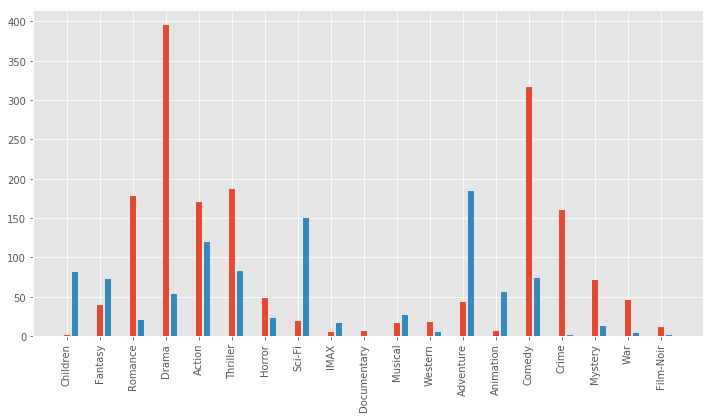

In [302]:
plt.figure(figsize=(12, 6))
plt.bar(np.arange(0, len(list(cluster_zero_genre_count.values()))), list(cluster_zero_genre_count.values()), width = 0.2)
plt.bar(np.arange(0.25, len(list(cluster_zero_genre_count.values())) + 0.25), list(cluster_one_genre_count.values()), width = 0.2)
plt.xticks(range(len(genres)), genres, rotation = 90)
plt.show()